In [10]:
import torch
import torch.nn as nn
from myTimedistributed import TimeDistributed

input_size = 1
hidden_size = 64
sequence_length = 10
batch_size = 16

# Input tensor
x = torch.randn(batch_size, sequence_length, input_size)

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, batch_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.encoder1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size*2, batch_first=True)
        self.encoder2 = nn.LSTM(input_size=hidden_size*2, hidden_size=hidden_size, batch_first=True)
    
    def forward(self, x):
        encoded_output1, _ = self.encoder1(x)   # (3, 10, 128)
        _, hidden_state = self.encoder2(encoded_output1) # (3, 10, 64), (1, 3, 64)
        expanded_tensor = hidden_state[0].reshape(self.batch_size, 1, self.hidden_size)
        reshaped_tensor = expanded_tensor.expand(-1, self.sequence_length, -1)   # (3, 10, 64)
        return reshaped_tensor


class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length):
        super(Decoder, self).__init__()
        self.decoder1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.decoder2 = nn.LSTM(input_size=hidden_size, hidden_size=128, batch_first=True)
        self.timedistributed = TimeDistributed(nn.Linear(hidden_size*2, input_size))
    
    def forward(self, x):
        decoded_output1, _ = self.decoder1(x)   # (3, 10, 64)
        decoded_output2, _ = self.decoder2(decoded_output1) # (3, 10, 128)
        distributer_output = self.timedistributed(decoded_output2)  # (3, 10, 2)
        return distributer_output


class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, batch_size):
        super(LSTM_Autoencoder, self).__init__()
        self.encoder = Encoder(
            input_size = input_size,
            hidden_size= hidden_size,
            sequence_length= sequence_length,
            batch_size=batch_size
        )
        self.decoder = Decoder(
            input_size = input_size,
            hidden_size= hidden_size,
            sequence_length= sequence_length
        )
    
    def forward(self, x):
        encoded_output = self.encoder(x)
        decoded_output = self.decoder(encoded_output)

        return decoded_output

model = LSTM_Autoencoder(input_size, hidden_size, sequence_length, batch_size)

output = model(x)

In [14]:
# Input tensor
x = torch.randn(batch_size, sequence_length, input_size)
# (3, 10, 1)

# Create LSTM layer
# 사이즈 늘리기
lstm = nn.LSTM(input_size=input_size, hidden_size=128, batch_first=True)
output, _ = lstm(x) # (3, 10, 128)

# Create LSTM layer
lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, batch_first=True)
output, hidden_state = lstm(output)
print(len(hidden_state[0]))
print(len(hidden_state[0][0]))
print(len(hidden_state[0][0][0]))
print(output.shape)  # (3, 10, 64)
print(hidden_state[0].shape)  # (1, 3, 64)

# Reshape the tensor to size (3, 1, 64)
expanded_tensor = hidden_state[0].reshape(batch_size, 1, hidden_size)
reshaped_tensor = expanded_tensor.expand(-1, sequence_length, -1)
print(reshaped_tensor.shape)  # (3, 10, 64)


# Create LSTM layer
lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
output, _ = lstm(reshaped_tensor)   # (3, 10, 64)

# Create LSTM layer
lstm = nn.LSTM(input_size=hidden_size, hidden_size=128, batch_first=True)
output, _ = lstm(output)    # (3, 10, 128)

# # 1번 ------------ Linear 모델 사용
# # Create Linear layer to be applied at each time step
# linear = nn.Linear(128, input_size)
# output_sequence = linear(output)


# 2번 ------------- pytorch 버전 Timedistributed 사용
dense_layer = nn.Linear(128, input_size)
timedistributed = TimeDistributed(dense_layer)
timedistributed(output)

1
16
64
torch.Size([16, 10, 64])
torch.Size([1, 16, 64])
torch.Size([16, 10, 64])


tensor([[[-6.3508e-03],
         [-4.7442e-03],
         [-3.3574e-03],
         [-2.1010e-03],
         [-1.0070e-03],
         [-1.0784e-04],
         [ 5.9251e-04],
         [ 1.1136e-03],
         [ 1.4869e-03],
         [ 1.7457e-03]],

        [[-6.3503e-03],
         [-4.7335e-03],
         [-3.3322e-03],
         [-2.0619e-03],
         [-9.5644e-04],
         [-4.8671e-05],
         [ 6.5774e-04],
         [ 1.1830e-03],
         [ 1.5590e-03],
         [ 1.8196e-03]],

        [[-6.3791e-03],
         [-4.7900e-03],
         [-3.4096e-03],
         [-2.1536e-03],
         [-1.0575e-03],
         [-1.5562e-04],
         [ 5.4729e-04],
         [ 1.0706e-03],
         [ 1.4456e-03],
         [ 1.7059e-03]],

        [[-6.2951e-03],
         [-4.6632e-03],
         [-3.2764e-03],
         [-2.0315e-03],
         [-9.5146e-04],
         [-6.4844e-05],
         [ 6.2541e-04],
         [ 1.1388e-03],
         [ 1.5063e-03],
         [ 1.7610e-03]],

        [[-6.3757e-03],
        

In [9]:
print(hidden_state)

(tensor([[[-0.0650, -0.0500,  0.1235,  ..., -0.0144, -0.0767,  0.0115],
         [-0.0644, -0.0502,  0.1238,  ..., -0.0150, -0.0771,  0.0115],
         [-0.0609, -0.0493,  0.1255,  ..., -0.0149, -0.0796,  0.0094],
         ...,
         [-0.0636, -0.0507,  0.1236,  ..., -0.0148, -0.0768,  0.0126],
         [-0.0598, -0.0474,  0.1242,  ..., -0.0180, -0.0811,  0.0087],
         [-0.0570, -0.0470,  0.1248,  ..., -0.0180, -0.0827,  0.0078]]],
       grad_fn=<StackBackward0>), tensor([[[-0.1285, -0.1028,  0.2394,  ..., -0.0279, -0.1553,  0.0258],
         [-0.1274, -0.1027,  0.2408,  ..., -0.0290, -0.1558,  0.0258],
         [-0.1206, -0.1001,  0.2458,  ..., -0.0288, -0.1603,  0.0209],
         ...,
         [-0.1263, -0.1027,  0.2416,  ..., -0.0286, -0.1546,  0.0280],
         [-0.1181, -0.0966,  0.2423,  ..., -0.0348, -0.1639,  0.0194],
         [-0.1131, -0.0945,  0.2457,  ..., -0.0348, -0.1665,  0.0174]]],
       grad_fn=<StackBackward0>))


In [6]:
import torch
# from tensorflow.python.
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
# print(torch.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


True
NVIDIA GeForce GTX 1650 SUPER
cuda:0


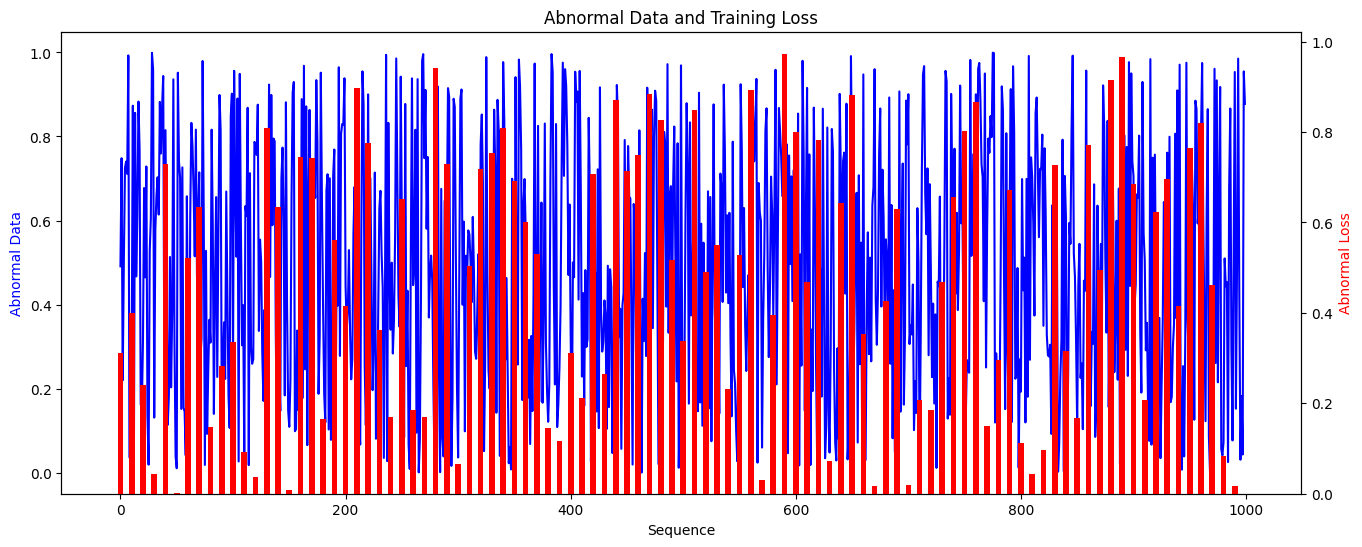

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
abnormal_data = np.random.rand(1000)  # Example abnormal_data (replace with your actual data)
abnormal_loss_cpu = np.random.rand(100)  # Example abnormal_loss_cpu (replace with your actual data)

# Create the figure and the first Axes object
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.plot(range(len(abnormal_data)), abnormal_data, 'b')
ax1.set_xlabel('Sequence')
ax1.set_ylabel('Abnormal Data', color='b')

# Create the second Axes object sharing the same x-axis
ax2 = ax1.twinx()
ax2.bar(np.arange(0, len(abnormal_loss_cpu) * 10, 10), abnormal_loss_cpu, width=5, align='center', color='r')
ax2.set_ylabel('Abnormal Loss', color='r')

plt.title('Abnormal Data and Training Loss')

plt.show()


In [24]:
import numpy as np

a= [[1,2,3,4],[2,3,4,5]]
a= np.array(a)
print(a.shape[1])
print(len(an)

4
2
